# MRI NIH : Data exploration

## Imports

In [1]:
from msct_image import Image
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

## Functions

In [2]:
def check_differences(liste, name):
    if liste.count(liste[0])==len(liste):
        print "All "+name+" are "
        print liste[0]
    else:
        print name+" : "
        print [(item, liste.count(item)) for item in set(liste)]

In [3]:
def plot_ranges(ranges, name):
    plt.plot(ranges["min"], label="min", color="b")
    plt.plot(ranges["max"], label="max", color="r")
    plt.plot(ranges["med"], label="median", color="g")
    plt.axes().set_yscale("log")
    plt.title(name+" ranges")
    plt.legend(loc="lower right")
    plt.xlabel("time point")
    plt.ylabel("mean intensity")
    plt.show()

In [4]:
def plot_sim(sims, name):
    plt.figure(figsize=(10,7))
    for sim in sims:
        plt.plot(sim)
        plt.xlabel("slice number")
        plt.ylabel("mean intensity")
        plt.title(name+" superior-to-inferior mean intensity")
    plt.show()

In [5]:
def count_labeled_slices(gt_dict, name):
    labeled_indexes = {}
    print name+" :"
    for type_gt in gt_dict.keys():
        labeled_indexes[type_gt] = {}
        print "  "+type_gt
        for tp, image in gt_dict[type_gt].iteritems():
            count = 0
            indexes = []
            for i in range(image.data.shape[2]):
                if np.max(image.data[::,::,i])>0:
                    count+=1
                    indexes.append(i)
            detail_slice_index = " "
            if count<image.data.shape[2]:
                detail_slice_index = " (on slices %s)" %indexes
            print "    tp %s : %d slices%s" %(tp, count, detail_slice_index)
            labeled_indexes[type_gt][tp]=indexes
    return labeled_indexes

In [6]:
def get_class_balance(gt_dict, gt_indexes, name):
    print name+" :"
    for type_gt in gt_dict:
        count = 0.
        for tp, image in gt_dict[type_gt].iteritems():
            count += np.count_nonzero(image.data)/float(len(gt_indexes[type_gt][tp])*image.data.shape[0]*image.data.shape[1])
        count = 100*count/float(len(gt_dict[type_gt]))
        print "  %s : %f%%" %(type_gt, count)

In [7]:
def plot_hist(image, gt, name):
    data = image*gt
    hist, ranges = np.histogram(data)
    plt.plot(ranges[:-1], hist)
    plt.title(name+" intensity histogram")
    plt.xlabel("intensity")
    plt.ylabel("number of pixels")
    plt.show()

## Paths

In [3]:
subject_dir = "/Users/frpau_local/Documents/nih/data/luisa_with_gt/"
tp_dirs = [tp_dir+"/" for tp_dir in os.listdir(subject_dir) if "tp" in tp_dir]

## Load raw images

In [10]:
images_cerv = []
images_thor = []
images_lumb = []


for tp_dir in tp_dirs:
    for seg_dir in [seg_dir for seg_dir in os.listdir(subject_dir+tp_dir) if not "." in seg_dir]:
        if "cerv" in seg_dir:
            if os.path.isfile(subject_dir+tp_dir+seg_dir+"/t2s_cerv.nii.gz"):
                images_cerv.append(Image(subject_dir+tp_dir+seg_dir+"/t2s_cerv.nii.gz"))
        elif "lumb" in seg_dir:
            if os.path.isfile(subject_dir+tp_dir+seg_dir+"/t2s_lumb.nii.gz"):
                images_lumb.append(Image(subject_dir+tp_dir+seg_dir+"/t2s_lumb.nii.gz"))
        elif "thor" in seg_dir:
            if os.path.isfile(subject_dir+tp_dir+seg_dir+"/t2s_thor.nii.gz"):
                images_thor.append(Image(subject_dir+tp_dir+seg_dir+"/t2s_thor.nii.gz"))

## Load ground truths

In [6]:
gt_cerv = {}
gt_thor = {}
gt_lumb = {}

# sturcture of gt dict :
# {type: {tp_number: image}} e.g. gt_cerv = {"gm": {"8": image}}

for tp_dir in tp_dirs:
    for seg_dir in [seg_dir for seg_dir in os.listdir(subject_dir+tp_dir) if not "." in seg_dir]:
        for image in [image for image in os.listdir(subject_dir+tp_dir+seg_dir) if "manual" in image]:
            image_spec = image.split('_')
            if image_spec[1] == "cerv":
                if image_spec[2] in gt_cerv.keys():
                    gt_cerv[image_spec[2]][tp_dir[:-1].split('_')[-1]] = Image(subject_dir+tp_dir+seg_dir+"/"+image)
                else:
                    gt_cerv[image_spec[2]]={tp_dir[:-1].split('_')[-1]:Image(subject_dir+tp_dir+seg_dir+"/"+image)}
            if image_spec[1] == "thor":
                if image_spec[2] in gt_thor.keys():
                    gt_thor[image_spec[2]][tp_dir[:-1].split('_')[-1]] = Image(subject_dir+tp_dir+seg_dir+"/"+image)
                else:
                    gt_thor[image_spec[2]]={tp_dir[:-1].split('_')[-1]:Image(subject_dir+tp_dir+seg_dir+"/"+image)}
            if image_spec[1] == "lumb":
                if image_spec[2] in gt_lumb.keys():
                    gt_lumb[image_spec[2]][tp_dir[:-1].split('_')[-1]] = Image(subject_dir+tp_dir+seg_dir+"/"+image)
                else:
                    gt_lumb[image_spec[2]]={tp_dir[:-1].split('_')[-1]:Image(subject_dir+tp_dir+seg_dir+"/"+image)}

## Number of time points

In [21]:
print "cerv : %d time points" %len(images_cerv)
print "thor : %d time points" %len(images_thor)
print "lumb : %d time points" %len(images_lumb)

cerv : 10 time points
thor : 10 time points
lumb : 9 time points


## Resolutions

In [12]:
cerv_res = [ im.dim[4:7] for im in images_cerv ]
check_differences(cerv_res, "cerv resolutions")

thor_res = [ im.dim[4:7] for im in images_thor ]
check_differences(thor_res, "thor resolutions")

lumb_res = [ im.dim[4:7] for im in images_lumb ]
check_differences(lumb_res, "lumb resolutions")

All cerv resolutions are 
(0.15, 0.15, 1.0)
All thor resolutions are 
(0.15, 0.15086704, 1.0)
All lumb resolutions are 
(0.15, 0.15, 1.0)


## Orientations

In [13]:
cerv_ori = [ im.orientation for im in images_cerv ]
check_differences(cerv_ori, "cerv orientation")

thor_ori = [ im.orientation for im in images_thor ]
check_differences(thor_ori, "thor orientation")

lumb_ori = [ im.orientation for im in images_lumb ]
check_differences(lumb_ori, "lumb orientation")

All cerv orientation are 
RAS
All thor orientation are 
RAS
All lumb orientation are 
RAS


## Matrix sizes

In [14]:
cerv_mat = [ im.dim[0:2] for im in images_cerv ]
check_differences(cerv_mat, "cerv matrix sizes")

thor_mat = [ im.dim[0:2] for im in images_thor ]
check_differences(thor_mat, "thor matrix sizes")

lumb_mat = [ im.dim[0:2] for im in images_lumb ]
check_differences(lumb_mat, "lumb matrix sizes")

All cerv matrix sizes are 
(232, 174)
All thor matrix sizes are 
(232, 174)
All lumb matrix sizes are 
(232, 174)


## Numbers of slices

In [15]:
cerv_sli = [ im.dim[2] for im in images_cerv ]
check_differences(cerv_sli, "cerv numbers of slices")

thor_sli = [ im.dim[2] for im in images_thor ]
check_differences(thor_sli, "thor numbers of slices")

lumb_sli = [ im.dim[2] for im in images_lumb ]
check_differences(lumb_sli, "lumb numbers of slices")

All cerv numbers of slices are 
20
All thor numbers of slices are 
24
All lumb numbers of slices are 
27


## Ranges

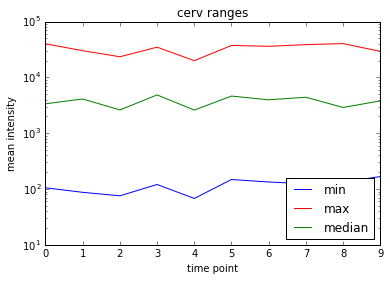

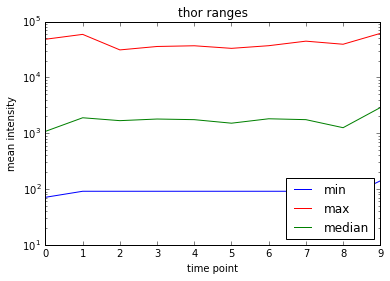

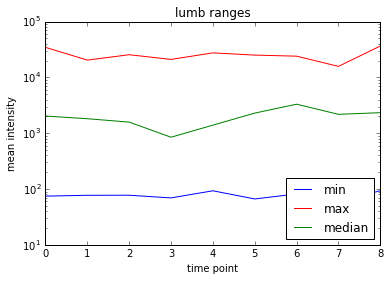

In [16]:
cerv_ran = {"min":[np.min(im.data) for im in images_cerv], "max":[np.max(im.data) for im in images_cerv], "med":[np.median(im.data) for im in images_cerv]}
plot_ranges(cerv_ran, "cerv")

thor_ran = {"min":[np.min(im.data) for im in images_thor], "max":[np.max(im.data) for im in images_thor], "med":[np.median(im.data) for im in images_thor]}
plot_ranges(thor_ran, "thor")

lumb_ran = {"min":[np.min(im.data) for im in images_lumb], "max":[np.max(im.data) for im in images_lumb], "med":[np.median(im.data) for im in images_lumb]}
plot_ranges(lumb_ran, "lumb")

## Superior-to-inferior mean intensity

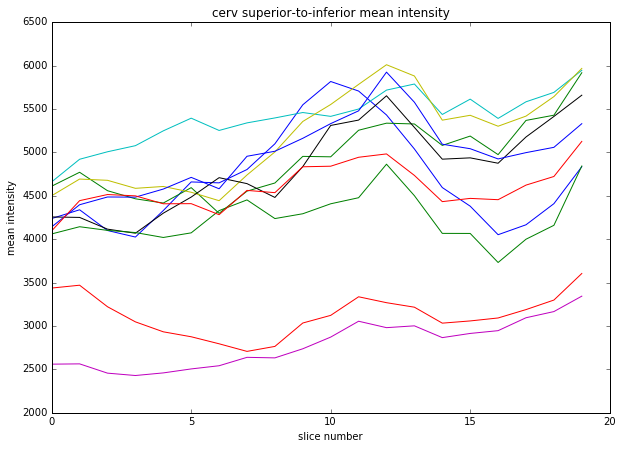

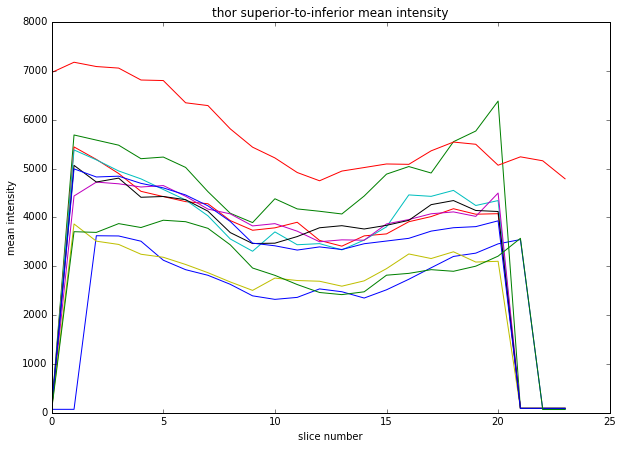

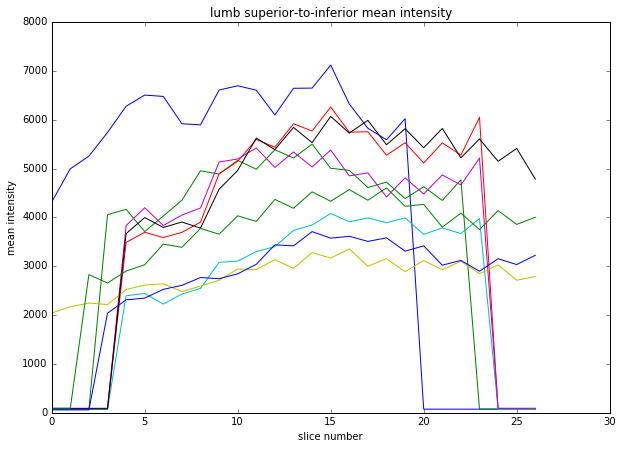

In [17]:
cerv_sim = [ np.mean(im.data, axis=(0,1)) for im in images_cerv ]
plot_sim(cerv_sim, "cerv")

thor_sim = [ np.mean(im.data, axis=(0,1)) for im in images_thor ]
plot_sim(thor_sim, "thor")

lumb_sim = [ np.mean(im.data, axis=(0,1)) for im in images_lumb ]
plot_sim(lumb_sim, "lumb")

## Comparing N4 to raw 

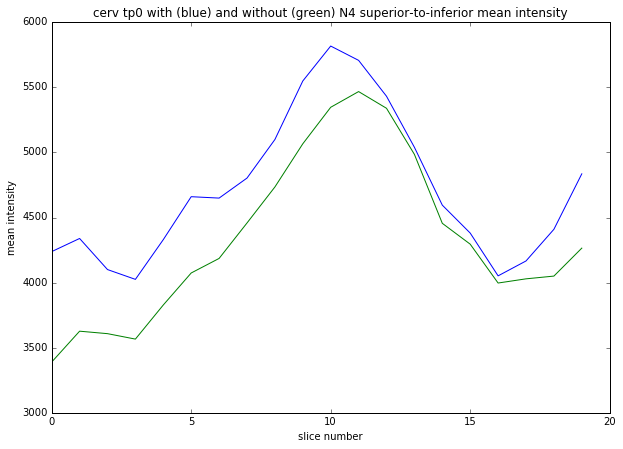

(20,)


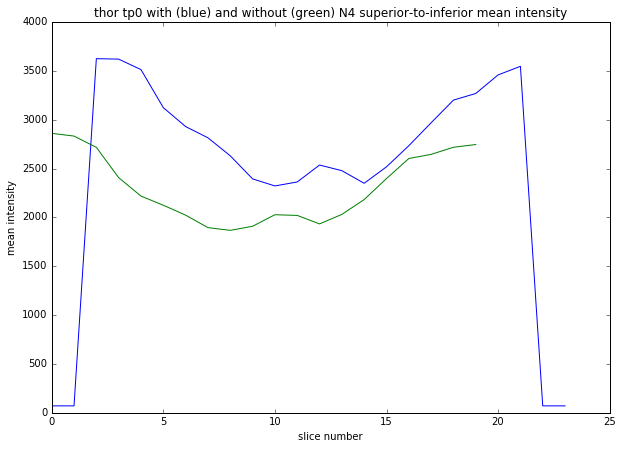

In [18]:
cerv_n4 = images_cerv[0]
cerv_no_n4 = Image("/Users/frpau_local/Documents/nih/original_data/marmoset_SC_forCharley/upper_segment/Luisa_cerv_TP0_noN4.nii")

cerv_n4_sim = np.mean(cerv_n4.data, axis=(0,1))
cerv_no_n4_sim = np.mean(cerv_no_n4.data, axis=(0,1))

cerv_no_n4_sim = cerv_no_n4_sim[::-1, ::]

plot_sim([cerv_n4_sim, cerv_no_n4_sim], "cerv tp0 with (blue) and without (green) N4")

thor_n4 = images_thor[0]
thor_no_n4 = Image("/Users/frpau_local/Documents/nih/original_data/marmoset_SC_forCharley/middle_segment/Luisa_ax_th_T0_noN4.nii")

thor_n4_sim = np.mean(thor_n4.data, axis=(0,1))
thor_no_n4_sim = np.mean(thor_no_n4.data, axis=(0,1))

print thor_no_n4_sim.shape

thor_no_n4_sim = thor_no_n4_sim[::-1]

plot_sim([thor_n4_sim, thor_no_n4_sim], "thor tp0 with (blue) and without (green) N4")

## Labeled slices

In [113]:
gt_cerv_indexes = count_labeled_slices(gt_cerv, "cerv")
print " "
gt_thor_indexes = count_labeled_slices(gt_thor, "thor")
print " "
gt_lumb_indexes = count_labeled_slices(gt_lumb, "lumb")

cerv :
  gm
    tp 0 : 20 slices 
  csf
    tp 0 : 20 slices 
  focal
    tp 9 : 3 slices (on slices [7, 16, 17])
    tp 8 : 2 slices (on slices [7, 16])
    tp 7 : 1 slices (on slices [7])
  nawm
    tp 0 : 20 slices 
 
thor :
  gm
    tp 0 : 20 slices (on slices [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
  csf
    tp 0 : 20 slices (on slices [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
  focal
    tp 1 : 1 slices (on slices [16])
    tp 3 : 3 slices (on slices [15, 16, 17])
    tp 2 : 1 slices (on slices [16])
    tp 5 : 4 slices (on slices [15, 16, 17, 18])
    tp 4 : 3 slices (on slices [15, 16, 17])
    tp 7 : 6 slices (on slices [14, 15, 16, 17, 18, 20])
    tp 6 : 2 slices (on slices [15, 16])
    tp 9 : 9 slices (on slices [4, 12, 14, 15, 16, 17, 19, 20, 21])
    tp 8 : 5 slices (on slices [14, 15, 16, 17, 20])
  nawm
    tp 0 : 20 slices (on slices [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2

## Class balance

In [107]:
get_class_balance(gt_cerv, gt_cerv_indexes, "cerv")
print " "
get_class_balance(gt_thor, gt_thor_indexes, "thor")
print " "
get_class_balance(gt_lumb, gt_lumb_indexes, "lumb")

cerv :
  gm : 0.197557%
  csf : 0.365017%
  focal : 0.038259%
  nawm : 0.867519%
 
thor :
  gm : 0.086578%
  csf : 0.250694%
  focal : 0.158589%
  nawm : 0.716781%
 
lumb :
  gm : 0.314606%
  csf : 0.717152%
  nawm : 0.679870%


## Label orientations

In [7]:
print "cerv :"
for type_gt, item in gt_cerv.iteritems():
    print "  "+type_gt
    for tp, image in item.iteritems():
        print "    "+tp+" "+image.orientation
print " "
print "thor :"
for type_gt, item in gt_thor.iteritems():
    print "  "+type_gt
    for tp, image in item.iteritems():
        print "    "+tp+" "+image.orientation
print " "
print "lumb :"
for type_gt, item in gt_lumb.iteritems():
    print "  "+type_gt
    for tp, image in item.iteritems():
        print "    "+tp+" "+image.orientation

cerv :
  gm
    0 RAS
  csf
    0 RAS
  focal
    9 RAS
    8 RAS
    7 RAS
  nawm
    0 RAS
 
thor :
  gm
    0 RAS
  csf
    0 RAS
  focal
    1 RAS
    3 RAS
    2 RAS
    5 RAS
    4 RAS
    7 RAS
    6 RAS
    9 RAS
    8 RAS
  nawm
    0 RAS
 
lumb :
  gm
    1 RAS
  csf
    1 RAS
  nawm
    1 RAS
